In [1]:
# Script based on notebook by chattob: https://www.kaggle.com/chattob
# Link https://www.kaggle.com/chattob/intel-mobileodt-cervical-cancer-screening/cervix-segmentation-gmm
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import math
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure
from glob import glob
import os
%matplotlib inline

In [2]:
TRAIN_DATA = '/ssd/cervical/train/'
#TEST_DATA = "../input/test"
ADDITIONAL_DATA = "/ssd/cervical/additional/"

In [3]:
train_files = glob(os.path.join(TRAIN_DATA, "*", "*.jpg"))
additional_files = glob(os.path.join(ADDITIONAL_DATA, "*", "*.jpg"))

In [4]:
additional_files[0]
os.path.dirname(additional_files[0])

'/ssd/cervical/additional/Type_1'

In [5]:
def get_image_data(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else:
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i - position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif (height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area = maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea

In [7]:
def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r - 1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (
    int(maxArea[3] + 1 - maxArea[0] / abs(maxArea[1] - maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

In [8]:
def cropCircle(img):
    if (img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
    else:
        tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    ff = np.zeros((gray.shape[0], gray.shape[1]), 'uint8')
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0] + 2, gray.shape[1] + 2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1] / 2), int(gray.shape[0] / 2)), 1)
    # cv2.circle(ff, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 3, 3, -1)

    rect = maxRect(ff)
    img_crop = img[min(rect[0], rect[2]):max(rect[0], rect[2]), min(rect[1], rect[3]):max(rect[1], rect[3])]
    cv2.rectangle(ff, (min(rect[1], rect[3]), min(rect[0], rect[2])), (max(rect[1], rect[3]), max(rect[0], rect[2])), 3,
                  2)

    return img_crop

In [9]:
def Ra_space(img, Ra_ratio, a_threshold):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    
    w = img.shape[0]
    h = img.shape[1]
    Ra = np.zeros((w * h, 2))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w / 2 - i) * (w / 2 - i) + (h / 2 - j) * (h / 2 - j))
            Ra[i * h + j, 0] = R
            Ra[i * h + j, 1] = min(imgLab[i][j][1], a_threshold)

    Ra[:, 0] /= max(Ra[:, 0])
    Ra[:, 0] *= Ra_ratio
    Ra[:, 1] /= max(Ra[:, 1])

    return Ra,imgLab

In [10]:
all_files = []
all_files.extend(additional_files)
all_files.extend(train_files)

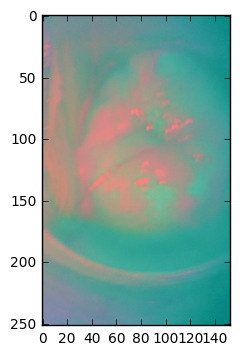

In [11]:
clss = int(os.path.basename(os.path.dirname(all_files[0])).split('_')[1])
img_id = os.path.basename(all_files[0])
img = get_image_data(all_files[0])
cropped_img = cropCircle(img)
Ra ,lab = Ra_space(cropped_img, 1.0, 150)
w,h,_=np.shape(cropped_img)
plt.imshow(lab)

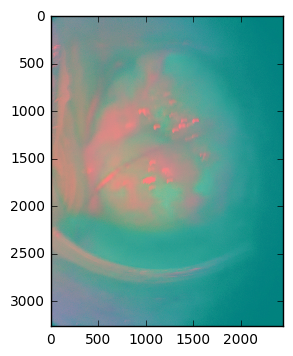

In [12]:
imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
plt.imshow(imgLab)

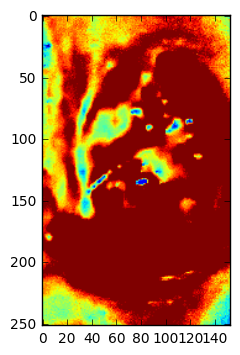

In [13]:
a_channel = np.reshape(Ra[:, 1], (w, h))
plt.imshow(a_channel)

[[ 1.          0.92666667]
 [ 0.99650692  0.94666667]
 [ 0.99304807  0.96      ]
 ..., 
 [ 0.98719401  0.88      ]
 [ 0.9906733   0.86666667]
 [ 0.99418687  0.88      ]]
(38556, 2)
1


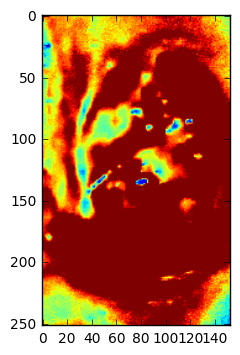

In [14]:
a_channel = np.reshape(Ra[:, 1], (w, h))
plt.subplot(121)
plt.imshow(a_channel)

g = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0, init_params='kmeans')
print Ra
print np.shape(Ra)
print clss
#print img_id

#plt.imshow(cropped_img) 
#plt.imshow(Ra)

In [15]:
image_array_sample = shuffle(Ra, random_state=0)[:1000]
print image_array_sample

[[ 0.44095273  1.        ]
 [ 0.16989907  0.97333333]
 [ 0.46132525  0.98      ]
 ..., 
 [ 0.60621359  1.        ]
 [ 0.72286813  0.94666667]
 [ 0.79776614  0.99333333]]


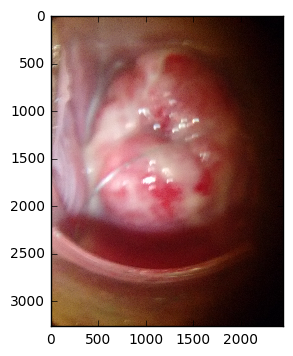

In [16]:
plt.imshow(img)

In [31]:
print len(glob('/ssd/cervical/train/Type_1/*.jpg'))
print len(glob('/ssd/cervical/train/Type_2/*.jpg'))
print len(glob('/ssd/cervical/train/Type_3/*.jpg'))
print len(glob('/ssd/cervical/additional/Type_3/*.jpg'))

250
781
450
1976


In [17]:
def open_csv(csv_path , type_ , start_flag =True):
    """
    param: csv_path is path which csv file is saved 
    """
    
    f= open(csv_path, type_)
    if start_flag ==True:
        f.write("image_name,type,clss,img_shp_0_init,img_shape1_init,img_shp_0,img_shp_1,sh0_start,sh1_start,sh0_end,sh1_end\n")
    return f

In [18]:
def write_csv(out, info_package ):
    img_id , img_type , clss , initial_shape , img ,x,y,w,h = info_package
    
    out.write(img_id)
    out.write(',' + img_type)
    out.write(',' + str(clss))
    out.write(',' + str(initial_shape[0]))
    out.write(',' + str(initial_shape[1]))
    out.write(',' + str(img.shape[0]))
    out.write(',' + str(img.shape[1]))
    out.write(',' + str(y))
    out.write(',' + str(x))
    out.write(',' + str(y + h))
    out.write(',' + str(x + w))
    out.write('\n')
    out.close()

In [38]:
temp_=[]
for line in all_files:
    if 'Type_1' in line and 'additional' in line :
        continue;
    elif 'Type_2' in line and 'additional' in line :
        continue;
    elif 'Type_3' in line and 'additional' in line :
        continue;
    elif 'Type_1' in line and 'train' in line :
        continue;
    elif 'Type_2' in line and 'train' in line :
        continue;

    temp_.append(line)
all_files= temp_

In [39]:
len(all_files)

450

Go for /ssd/cervical/train/Type_3/1000.jpg
Go for /ssd/cervical/train/Type_3/1003.jpg
Go for /ssd/cervical/train/Type_3/1004.jpg
Go for /ssd/cervical/train/Type_3/1007.jpg
Go for /ssd/cervical/train/Type_3/1008.jpg
Go for /ssd/cervical/train/Type_3/1009.jpg
Go for /ssd/cervical/train/Type_3/1015.jpg
Go for /ssd/cervical/train/Type_3/1020.jpg
Go for /ssd/cervical/train/Type_3/1028.jpg
Go for /ssd/cervical/train/Type_3/1029.jpg
Go for /ssd/cervical/train/Type_3/1030.jpg
Go for /ssd/cervical/train/Type_3/1031.jpg
Go for /ssd/cervical/train/Type_3/1034.jpg
Go for /ssd/cervical/train/Type_3/1037.jpg
Go for /ssd/cervical/train/Type_3/1041.jpg
Go for /ssd/cervical/train/Type_3/1045.jpg
Go for /ssd/cervical/train/Type_3/1048.jpg
Go for /ssd/cervical/train/Type_3/1052.jpg
Go for /ssd/cervical/train/Type_3/1053.jpg
Go for /ssd/cervical/train/Type_3/106.jpg
Go for /ssd/cervical/train/Type_3/1060.jpg
Go for /ssd/cervical/train/Type_3/1062.jpg
Go for /ssd/cervical/train/Type_3/1063.jpg
Go for /ssd/

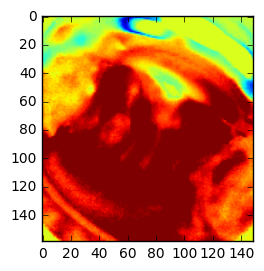

In [42]:
def write_rectangles_csv():
    
    

    # for f in sorted(train_files + test_files + additional_files):
    #additional_files[0]
            #'/ssd/cervical/additional/Type_1/2668.jpg'
    #type1_add=open_csv('rectangles_additional_type1.csv','a')
    type1_train=open_csv('rectangles_train_type1.csv','a')

    #type2_add=open_csv('rectangles_additional_type2.csv','a')
    type2_train=open_csv('rectangles_train_type2.csv', 'a')

    type3_add=open_csv('rectangles_additional_type3.csv','a')
    type3_train=open_csv('rectangles_train_type3.csv','a')

    for ind,f in enumerate(sorted(all_files)):
        
        type_=os.path.dirname(additional_files[ind]).split('/')[-1]

        if 'Type_1/994.jpg' in f or 'Type_2/6914.jpg' in f:
            continue 
        #'Type_1/6914.jpg' -->Type_2/6914.jpg'
        print('Go for {}'.format(f))
        img_id = os.path.basename(f)
#        img_type = 'test'
#        clss = -1
        if TRAIN_DATA in f:
            img_type = 'train'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
        if ADDITIONAL_DATA in f:
            img_type = 'additional'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
        try:
            img = get_image_data(f) # get image pixel infomation 
        except:
            print('Image read error: {}. Skip it!'.format(f))
            continue
        if img is None:
            print('Problem with image: {}. Skip it!'.format(f))
            continue
        initial_shape = img.shape[:2]

        img = cropCircle(img)
        w = img.shape[0]
        h = img.shape[1]

        imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

        # Saturating the a-channel at 150 helps avoiding wrong segmentation
        # in the case of close-up cervix pictures where the bloody os is falsly segemented as the cervix.
        Ra , _ = Ra_space(img, 1.0, 150)
        a_channel = np.reshape(Ra[:, 1], (w, h))
        plt.subplot(121)
        plt.imshow(a_channel)

        g = mixture.GaussianMixture(n_components=2, covariance_type='diag', random_state=0, init_params='kmeans')
        image_array_sample = shuffle(Ra, random_state=0)[:1000]
        g.fit(image_array_sample)
        labels = g.predict(Ra)
        labels += 1  # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.

        # The cluster that has the highest a-mean is selected.
        labels_2D = np.reshape(labels, (w, h))
        gg_labels_regions = measure.regionprops(labels_2D, intensity_image=a_channel)
        gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
        cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

        mask = np.zeros((w * h, 1), 'uint8')
        mask[labels == cervix_cluster] = 255
        mask_2D = np.reshape(mask, (w, h))

        cc_labels = measure.label(mask_2D, background=0)
        regions = measure.regionprops(cc_labels)
        areas = [prop.area for prop in regions]

        regions_label = [prop.label for prop in regions]
        largestCC_label = regions_label[areas.index(max(areas))]
        mask_largestCC = np.zeros((w, h), 'uint8')
        mask_largestCC[cc_labels == largestCC_label] = 255

        img_masked = img.copy()
        img_masked[mask_largestCC == 0] = (0, 0, 0)
        img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY)

        _, thresh_mask = cv2.threshold(img_masked_gray, 0, 255, 0)

        kernel = np.ones((11, 11), np.uint8)
        thresh_mask = cv2.dilate(thresh_mask, kernel, iterations=1)
        thresh_mask = cv2.erode(thresh_mask, kernel, iterations=2)
        _, contours_mask, _ = cv2.findContours(thresh_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        try:
            main_contour = sorted(contours_mask, key=cv2.contourArea, reverse=True)[0]
        except:
            print('Contour problem for {}. skip it!'.format(f))
            continue

        x, y, w, h = cv2.boundingRect(main_contour)
        info_package=[]
        if TRAIN_DATA in f:
            img_type = 'train'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
            info_package=img_id , img_type , clss , initial_shape , img ,x,y,w, h 

            if clss == 0:
                type1_train=open_csv('rectangles_train_type1.csv','a' ,False)
                write_csv(type1_train ,info_package)
            elif clss == 1:
                type2_train=open_csv('rectangles_train_type2.csv','a' ,False)
                write_csv(type2_train ,info_package)
            elif clss == 2:
                type3_train=open_csv('rectangles_train_type3.csv','a' ,False)
                write_csv(type3_train ,info_package)
                
        if ADDITIONAL_DATA in f:
            img_type = 'additional'
            clss = int(os.path.basename(os.path.dirname(f)).split('_')[1]) - 1
            info_package=img_id , img_type , clss , initial_shape , img ,x,y,w, h 
            
            if clss == 0:
                type1_add=open_csv('rectangles_additional_type1.csv','a' , False)
                write_csv(type1_add ,info_package)
            elif clss == 1:
                type2_add=open_csv('rectangles_additional_type2.csv','a' , False)
                write_csv(type2_add ,info_package)
            elif clss == 2:
                type3_add=open_csv('rectangles_additional_type3.csv','a' , False)
                write_csv(type3_add ,info_package)
        

if __name__ == '__main__':
    write_rectangles_csv()